In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.integrate import ode
import sys
sys.path.append('/home/pablo/CinePy')

from constantes.lectura import lee_constantes_retardados
from modules.point_kinetics.direct_kinetic_solver import cinetica_directa
from modules.point_kinetics.reactimeter import reactimetro
from modules.point_kinetics.soluciones_analiticas import solucion_analitica_Ia
from modules.point_kinetics.soluciones_numericas import direct_pk_ODE_solver

<IPython.core.display.Javascript object>


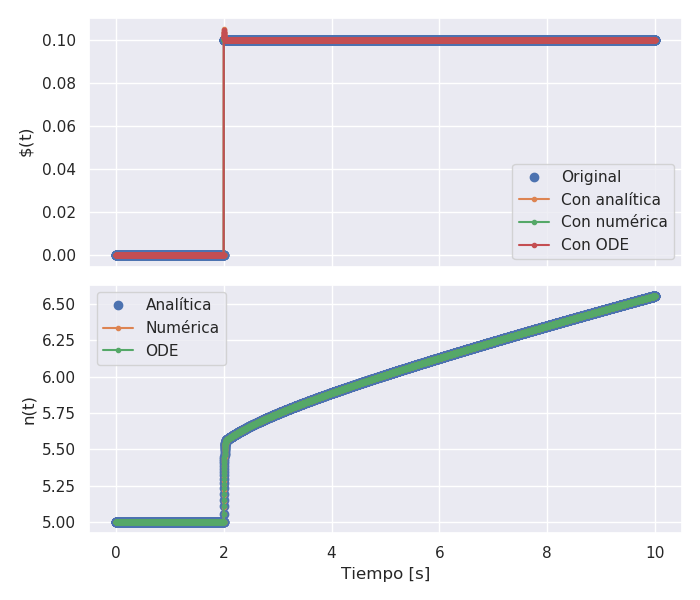

In [2]:

from constantes.constantes_reactores import RA3 as REACTOR
# Delayed neutron constants 
b, lam , beta = lee_constantes_retardados('Tuttle')
# Reduced generation time
Lambda_red = REACTOR.LAMBDA_REDUCIDO

constants = b, lam, Lambda_red

# Cantidad de puntos
Npunt = 10000
# Paso de integración
dt = 0.001
# Vector temporal
t = dt * np.arange(0, Npunt)
#t = np.linspace(0.0, tmax, Npunt)
# Paso de integración 
# dt = t[1]-t[0]
tmax = t[-1]

# Cambio en reactividad (en dólares)
rho_i = 0.0
rho_f = 0.1
# Tiempo del salto instantáneo
t0 = 2
# Valor inicial
n0 = 5
# Reactividad en función del tiempo
reactividad = rho_f * np.ones_like(t)
reactividad[t<=t0] = rho_i

n_analitica = solucion_analitica_Ia(t, rho_f, t0, n0, constants)
n_num, t_num = cinetica_directa(reactividad, n0, dt, lam, b, Lambda_red, 0)

# Reconstruyo la reactividad utilizando al reactímetro
rho_ana, t_ana, _ = reactimetro(n_analitica, dt, lam, b, Lambda_red)
rho_num, t_num, _ = reactimetro(n_num, dt, lam, b, Lambda_red)

# Numerical solution with integrate.ode

def rho(t):
    if t>= 2:
        return rho_f
    elif t<= 2:
        return rho_i

def S(t):
    return 0.0
    
t_ode, n_ode, _ = direct_pk_ODE_solver(rho, n0, dt, tmax, constants, S)
rho_ode, t_ode, _ = reactimetro(n_ode, dt, lam, b, Lambda_red)

##########################################
# Graficación
fig, ax = plt.subplots(2, 1, figsize=(7,6), sharex=True)
ax[0].plot(t, reactividad, 'o', label="Original")
ax[0].plot(t_ana, rho_ana, '.-', label="Con analítica")
ax[0].plot(t_num, rho_num, '.-', label="Con numérica")
ax[0].plot(t_ode, rho_ode, '.-', label="Con ODE")
ax[0].set_yscale('linear')
ax[0].set_ylabel(r'$\$$(t)')
ax[0].legend()

ax[1].plot(t, n_analitica, 'o', label='Analítica')
ax[1].plot(t_num, n_num, '.-', label='Numérica')
ax[1].plot(t_ode, n_ode, '.-', label='ODE')
ax[1].set_ylabel('n(t)')
ax[1].set_xlabel('Tiempo [s]')
ax[1].legend()

fig.tight_layout()
